BiRefNet HR Matting
====

**Bilateral Reference for High-Resolution Dichotomous Image Segmentation**

 * Paper: https://arxiv.org/abs/2401.03407

![BiRefNet Arch](../assets/birefnet_arch.png)

![BiRefNet Pipeline](../assets/birefnet_pipeline.png)

![BiRefNet Pipeline](../assets/birefnet_block.png)


```bash
conda create -n birefnet python=3.10 -y
conda activate birefnet

pip install -r https://raw.githubusercontent.com/ZhengPeng7/BiRefNet/main/requirements.txt

pip install transformers
pip install matplotlib
```

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from transformers import AutoModelForImageSegmentation

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

birefnet = AutoModelForImageSegmentation.from_pretrained(
    'ZhengPeng7/BiRefNet_HR-matting',
    trust_remote_code=True
)
torch.set_float32_matmul_precision(['high', 'highest'][0])
birefnet.eval().to(device).half();

/home/pyml/anaconda3/envs/birefnet/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/pyml/anaconda3/envs/birefnet/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/home/pyml/anaconda3/envs/birefnet/lib/python3.10/site-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)


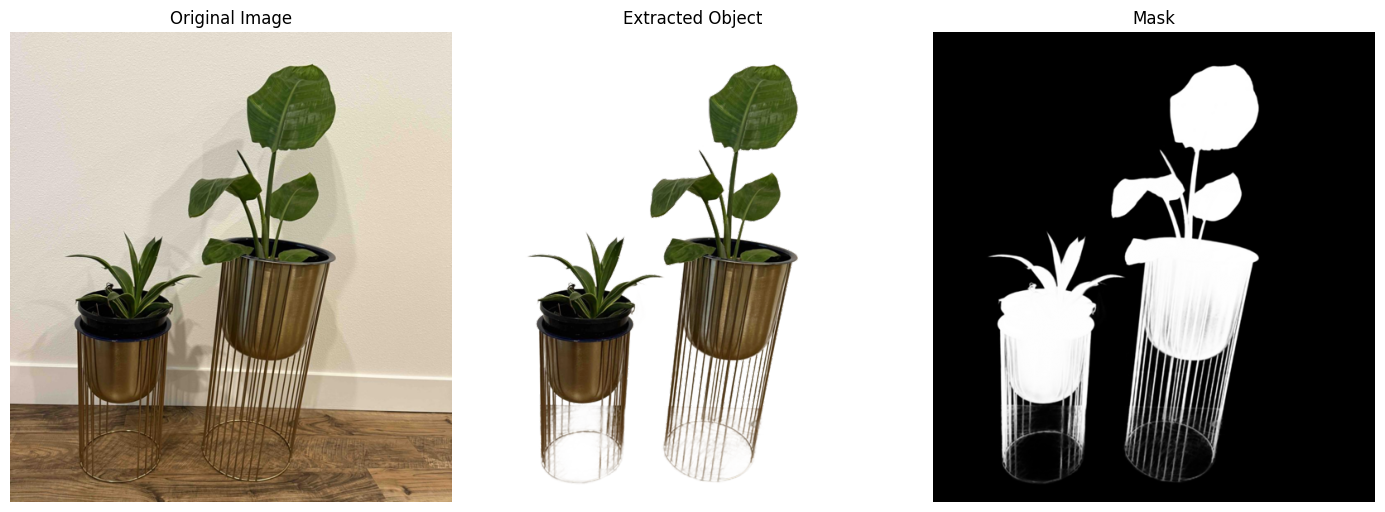

In [4]:
def extract_object(model, imagepath):
    # Data settings
    image_size = (2048, 2048)
    transform_image = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    image = Image.open(imagepath)
    input_images = transform_image(image).unsqueeze(0).to(device).half()

    # Prediction
    with torch.no_grad():
        preds = model(input_images)[-1].sigmoid().cpu()
    pred = preds[0].squeeze()
    pred_pil = transforms.ToPILImage()(pred)
    mask = pred_pil.resize(image.size)
    image.putalpha(mask)
    return image, mask

image_path = "../samples/plants.jpg"
orig_image = Image.open(image_path)
image, mask = extract_object(birefnet, image_path)

w, h = orig_image.size
orig_image = orig_image.resize((w // 2, h // 2))
image = image.resize((w // 2, h // 2))
mask = mask.resize((w // 2, h // 2))

fig, axes = plt.subplots(1, 3, figsize=(14, 5))
axes[0].imshow(orig_image)
axes[0].axis('off')
axes[0].set_title('Original Image')
axes[1].imshow(image)
axes[1].axis('off')
axes[1].set_title('Extracted Object')
axes[2].imshow(mask, cmap='gray')
axes[2].axis('off')
axes[2].set_title('Mask')
plt.tight_layout()
plt.show()